In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from keras.layers import Input, Dense, LSTM, Dropout, TimeDistributed, Lambda

# LSTM 기반의 가우시안 분포를 추정하는 Simple DeepAR
# 원리만 알면 뭐든 만들 수 있다.

# 챌린지
# 1. Seq2Seq로 변환.
# 2. LSTM이 아닌 다른 모델의 도입 (CNN-LSTM, GRU)
# 3. 분포 함수를 바꿔보기 => 분포 추정 계수를 mu, sigma가 아니고 다른 값으로 변경이 필요.
# 2주 정도 시간 들여서 해보기. (6주차에 솔루션 업로드)
# 4. 분포 함수 자체를 딥러닝으로 모델링 하기.  (5,6주차 때 다룰 예정, GAN/AutoEncoder)

class DeepAR(tf.keras.models.Model):
    def __init__(self, lstm_units, n_steps_in, n_steps_out, n_features):
        super().__init__()

        self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, input_shape=(n_steps_in, n_features))
        self.dense_mu = tf.keras.layers.Dense(1) # 정규분포 (가우시안 분포)의 평균
        self.dense_sigma = tf.keras.layers.Dense(1, activation='softplus') # 정규분포 (가우시안 분포)의 시그마

    def call(self, inputs, initial_state=None):
        outputs, state_h, state_c = self.lstm(inputs, initial_state=initial_state)

        mu = self.dense_mu(outputs) # 정규분포의 평균을 추정하는 레이어
        sigma = self.dense_sigma(outputs) # 정규분포의 표준편차를 추정하는 레이어
        state = [state_h, state_c]

        return [mu, sigma, state]

# 모델의 로스를 계산하는 부분,
def log_gaussian_loss(mu, sigma, y_true):
    """
    Gaussian loss function
    """
                              # 모델링된 mu와 sigma를 가지고 분포 생성
                                                                    # y_true=실제값과 분포에서 샘플링된 값의 차이를 구함.
    return -tf.reduce_sum(tfp.distributions.Normal(loc=mu, scale=sigma).log_prob(y_true))


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

df = pd.read_csv('/content/drive/MyDrive/시계열_교안/3주차/Gemini_ETHUSD_d.csv',  skiprows=1, parse_dates=True, index_col='Date')
df = df.sort_index().drop(['Symbol','Unix Timestamp'] , axis=1)

test_cutoff_date = df.index.max() - timedelta(days=90)

df_test = df[df.index > test_cutoff_date]['Close']
df_train = df[df.index <= test_cutoff_date]['Close']


############# 데이터를 정규화
training_mean = df_train.mean() # train의 평균
training_std = df_train.std() # train의 편차
df_training_value = (df_train - training_mean) / training_std # 데이터 = (원본 - 평균) / 편차로 정규화

test_mean = df_test.mean() # test의 평균
test_std = df_test.std() # test의 편차
df_test_value = (df_test - test_mean) / test_std # 데이터 = (원본 - 평균) / 편차로 정규화


##############

from numpy import array

def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

raw_seq = df_training_value
n_steps_in = 30
n_steps_out = 1

X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

test_raw_seq = df_test_value

test_X, test_y = split_sequence(test_raw_seq, n_steps_in, n_steps_out)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [ ]:
LSTM_UNITS = 128
EPOCHS = 100

model = DeepAR(LSTM_UNITS, n_steps_in, n_steps_out, n_features)

# optmizer
optimizer = tf.keras.optimizers.Adam()


# metric
rmse = tf.keras.metrics.RootMeanSquaredError()

def train_step(x, y):
    with tf.GradientTape() as tape:
        mu, sigma, _ = model(x)
        loss = log_gaussian_loss(mu, sigma, y) # Forward Learning
    # backword
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    rmse(y, mu)

for epoch in range(EPOCHS):
    train_step(X, y)
    print('Epoch %d, RMSE %.4f' % (epoch + 1, rmse.result().numpy()))
    rmse.reset_states()

Epoch 1, RMSE 0.9347
Epoch 2, RMSE 0.9026
Epoch 3, RMSE 0.8635
Epoch 4, RMSE 0.8220
Epoch 5, RMSE 0.7784
Epoch 6, RMSE 0.7333
Epoch 7, RMSE 0.6880
Epoch 8, RMSE 0.6443
Epoch 9, RMSE 0.6048
Epoch 10, RMSE 0.5726
Epoch 11, RMSE 0.5506
Epoch 12, RMSE 0.5405
Epoch 13, RMSE 0.5407
Epoch 14, RMSE 0.5457
Epoch 15, RMSE 0.5484
Epoch 16, RMSE 0.5452
Epoch 17, RMSE 0.5368
Epoch 18, RMSE 0.5266
Epoch 19, RMSE 0.5174
Epoch 20, RMSE 0.5108
Epoch 21, RMSE 0.5067
Epoch 22, RMSE 0.5040
Epoch 23, RMSE 0.5015
Epoch 24, RMSE 0.4996
Epoch 25, RMSE 0.5014
Epoch 26, RMSE 0.5038
Epoch 27, RMSE 0.4958
Epoch 28, RMSE 0.4936
Epoch 29, RMSE 0.4919
Epoch 30, RMSE 0.4933
Epoch 31, RMSE 0.4901
Epoch 32, RMSE 0.4880
Epoch 33, RMSE 0.4880
Epoch 34, RMSE 0.4873
Epoch 35, RMSE 0.4874
Epoch 36, RMSE 0.4875
Epoch 37, RMSE 0.4875
Epoch 38, RMSE 0.4879
Epoch 39, RMSE 0.4876
Epoch 40, RMSE 0.4886
Epoch 41, RMSE 0.4865
Epoch 42, RMSE 0.4859
Epoch 43, RMSE 0.4878
Epoch 44, RMSE 0.4895
Epoch 45, RMSE 0.4846
Epoch 46, RMSE 0.47

In [ ]:
# 샘플링된 값들을 예측값으로 반환.
pred = model.predict(test_X)

In [ ]:
pred[0].shape

# median => 실제 예측값.
# 5% 퍼센타일 => lower bound
# 95% 퍼센타일 => upper bound

(60, 30, 1)

In [ ]:
test_y.shape # 라벨의 shape

(60, 1)

In [ ]:
test_y

array([[-1.16902354],
       [-1.76620325],
       [-0.98994393],
       [-0.97656869],
       [-0.92306773],
       [-0.84355935],
       [-0.92405848],
       [-0.78807687],
       [-0.78708611],
       [-0.94164445],
       [-1.13013626],
       [-1.11998099],
       [-0.96245038],
       [-0.93619528],
       [-1.25571491],
       [-1.22277219],
       [-0.9882101 ],
       [-0.64218768],
       [-0.50001382],
       [-0.42001007],
       [-0.11312261],
       [-0.25752567],
       [-0.29616525],
       [-0.33232794],
       [-0.63872002],
       [-0.56193623],
       [-0.32762184],
       [-0.29121146],
       [-0.55723013],
       [ 0.00527304],
       [ 0.579913  ],
       [ 0.45631587],
       [ 0.52789817],
       [ 0.37086294],
       [ 0.05580172],
       [ 0.31191281],
       [-0.06135548],
       [-0.09578434],
       [-0.20996926],
       [-0.10841651],
       [ 0.13605317],
       [-0.17876036],
       [-0.07373996],
       [ 0.28144698],
       [ 0.6371293 ],
       [ 1

In [ ]:
import numpy as np
lower_bound = []
upper_bound = []
median = []
for step_pred in pred[0]:
                           # 정규화된 값을 원래대로.
  lb = (np.quantile(step_pred, 0.05) + test_mean) * test_std
  ub = (np.quantile(step_pred, 0.95) + test_mean) * test_std
  med = (np.quantile(step_pred, 0.5) + test_mean) * test_std
  lower_bound.append(lb)
  upper_bound.append(ub)
  median.append(med)

In [ ]:
lower_bound

[15763.174462812996,
 15763.21162595064,
 15763.306899069526,
 15763.234681303511,
 15761.771772208553,
 15761.060932057111,
 15760.278277817384,
 15759.36189266467,
 15759.186526153526,
 15759.155608169109,
 15758.977537799237,
 15758.873255146822,
 15758.972845511833,
 15759.067522920299,
 15759.369356671976,
 15759.148698120756,
 15759.00842594399,
 15758.153639366321,
 15758.405571812165,
 15758.583542556056,
 15758.627044456844,
 15758.701744449878,
 15758.59553497325,
 15758.55061592899,
 15758.290500917445,
 15757.923948300215,
 15757.943406890496,
 15758.007194469712,
 15758.263842063996,
 15759.127980248459,
 15760.36074719301,
 15760.0886898179,
 15759.307298349506,
 15758.830179664477,
 15758.376344100416,
 15758.042722201173,
 15758.032459281367,
 15758.038040742676,
 15758.37574875096,
 15759.227025077005,
 15760.987234941545,
 15763.11551828369,
 15766.470085181116,
 15769.486285431838,
 15773.48163002892,
 15779.519575774984,
 15785.134582885186,
 15785.121193177523,
 15

In [ ]:
upper_bound

[15836.603409303316,
 15836.33447161711,
 15836.638094545508,
 15836.251864112712,
 15836.05908844283,
 15836.176123822304,
 15835.91903164107,
 15835.307494046254,
 15830.598035597648,
 15823.664597277597,
 15809.108667232013,
 15796.830137000214,
 15793.348371647568,
 15792.461616560804,
 15791.723558032105,
 15791.046727098013,
 15790.228618853664,
 15790.975389872852,
 15795.49145191434,
 15797.282347001874,
 15797.068200521491,
 15794.176950636569,
 15794.169102894773,
 15793.574140331753,
 15797.225738434083,
 15800.83359584122,
 15799.115424382124,
 15795.194480764772,
 15790.169399841543,
 15787.799449650509,
 15788.87715567551,
 15791.089413401329,
 15796.222515327574,
 15799.46297916795,
 15805.2644888878,
 15810.740796649101,
 15813.813271982279,
 15814.864219407531,
 15814.97729278932,
 15815.117653763155,
 15815.31041908541,
 15815.572212939107,
 15815.87221119039,
 15816.167379085653,
 15816.464575356245,
 15816.808215201265,
 15817.08681576529,
 15818.323772054497,
 1582

In [ ]:
test_cutoff_date

Timestamp('2020-08-22 00:00:00')

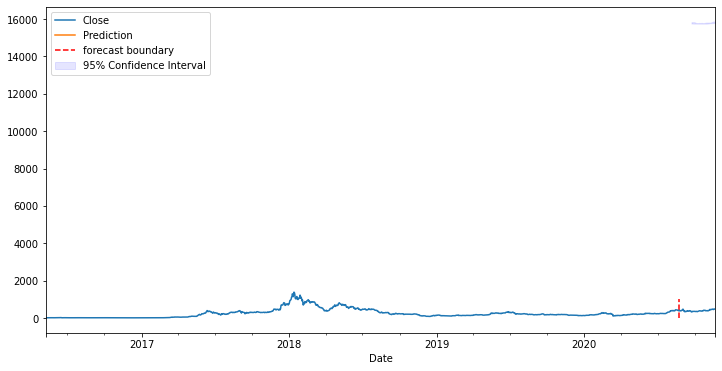

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)


df['Close'].plot(ax=ax)
ax.vlines('2020-08-22', 0, 1000, linestyle='--', color='r', label='forecast boundary')
ax.fill_between(df_test[30:].index, lower_bound, upper_bound, color='b', alpha=0.1, label='95% Confidence Interval')
ax.plot(df_test[30:].index, median, label='Prediction')
ax.legend(loc='upper left')
# plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Result (r2 score: {r2}")
# plt.show()